<img src="https://raw.githubusercontent.com/astrolabsoftware/fink-notebook-template/main/Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: Solar System Science

## Goal

This notebook shows how to explore the alerts tagged as `Solar System Object` (SSO) in the Fink database. 

## What is behind?

Each night, Fink labels alerts from the ZTF public stream for Solar System science. The labels are twofold: known objects from the [Minor Planet Center (MPC)](https://minorplanetcenter.net/), and new Solar System Object (SSO) candidates. Observations of MPC known objects are aggregated at the end of each night, and full orbits can be queried directly from the Science Portal, or via the REST API. New SSO candidates are tagged, and they can be queried, but there is no attempt, for the moment, to link them together to find new objects (to come!).

## Useful links

- API documentation: https://fink-portal.org/api
- Schema of Fink database: https://fink-portal.org/api/v1/columns
- MPC search: https://minorplanetcenter.net/db_search
- JPL Small-Body Database Browser: https://ssd.jpl.nasa.gov/sbdb.cgi

## Environment set up

To run this notebook, you need to import the following libraries (already installed in  colab):

In [1]:
import requests
import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

## Case study 1: Known objects from the Minor Planet Center

### Association criterion and nightly rate 

Each night, Fink collects more than 10,000 ZTF alerts associated to known solar system objects from the [Minor Planet Center (MPC)](https://minorplanetcenter.net/) database. This represents up to 5-10% of the total stream each night. The way we associate alerts to known MPC objects is the following:
- The alert must be within 5 arcseconds of a known MPC object (alerts are tagged up to 30 arcseconds from any known MPC objects).
- The distance to a known MPC object must be smaller than the distance to any known object from PANSTARRS (DR1).
- The number of prior detection of the alert is maximum 1 (i.e. spatial association to another alert).

### Querying the Fink database by number or designation

You can easily query the Fink database if you already know the number of the designation of an object. The numbers or designations are taken from the MPC archive. When searching for a particular asteroid or comet, it is best to use the IAU number, as in 4209 for asteroid "4209 Briggs". You can also try for numbered comet (e.g. 10P), or interstellar object (none so far...). If the number does not yet exist, you can search for designation. Here are some valid numbers/designations that you can try:

* Asteroids by number (default)
  * Asteroids (Main Belt): 9247, 4209, 1922
  * Asteroids (Hungarians): 18582, 77799
  * Asteroids (Jupiter Trojans): 4501, 1583
  * Asteroids (Mars Crossers): 302530
* Asteroids by designation (if number does not exist yet)
  * 2010JO69, 2017AD19, 2012XK111
* Comets by number (default)
  * 10P, 249P, 124P
* Comets by designation (if number does no exist yet)
  * C/2020V2, C/2020R2

Note for designation, you can also use space (2010 JO69 or C/2020 V2).

#### Example: search by asteroid number

Note you can access the description of all arguments for the API query at https://fink-portal.org/api/v1/sso:

In [2]:
sso_oid = '1922'

r = requests.post(
  'https://fink-portal.org/api/v1/sso',
  json={
    'n_or_d': sso_oid,  #number or designation
    'output-format': 'json' # default is json.
  }
)

# Format output in a DataFrame
pdfsso = pd.read_json(io.BytesIO(r.content))

You will get a pandas DataFrame whose rows are alerts from the Fink database that are associated to the asteroid number `1922` (main-belt asteroid). We recall that the DataFrame column schema can be read from https://fink-portal.org/api/v1/columns. In the Fink Web Portal, you would just enter the number in the search bar:

<img src="sso_search.png" width=1000 />

#### Extracting some properties

From the DataFrame, you can easily inspect some properties of the object:

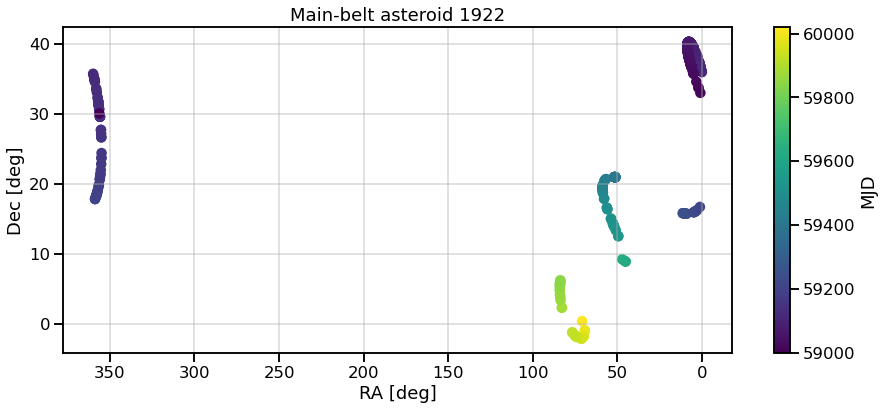

In [3]:
# Plot evolution of asteroid position

fig = plt.figure(figsize=(15, 6))

mjd = pdfsso['i:jd'].apply(lambda x: x - 2400000.5)
plt.scatter(pdfsso['i:ra'], pdfsso['i:dec'], c=mjd, marker='o')

plt.colorbar(label='MJD')
plt.gca().invert_xaxis()
plt.title('Main-belt asteroid {}'.format(sso_oid))
plt.grid(alpha=0.5)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]');

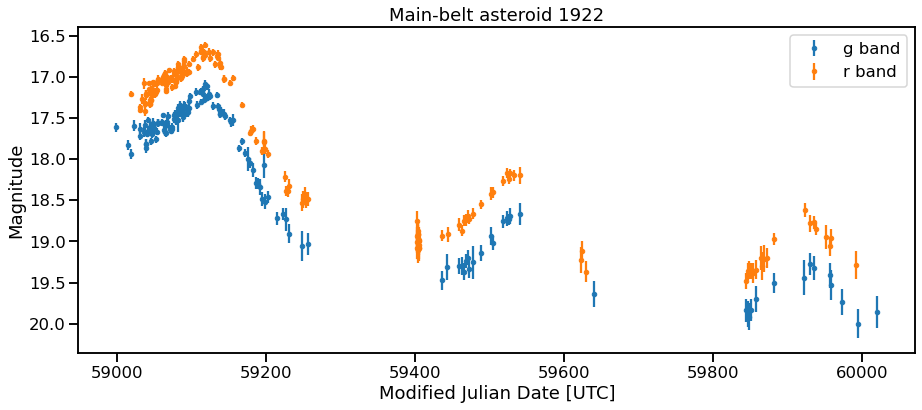

In [4]:
# plot light curve

fig = plt.figure(figsize=(15, 6))

mjd = pdfsso['i:jd'].apply(lambda x: x - 2400000.5)

filtdic = {1: 'g', 2: 'r'}
for filt in np.unique(pdfsso['i:fid']):
    mask = pdfsso['i:fid'] == filt
    plt.errorbar(
        mjd[mask], 
        pdfsso['i:magpsf'][mask], 
        pdfsso['i:sigmapsf'][mask], 
        marker='.', ls='', 
        label='{} band'.format(filtdic[filt])
    )

plt.gca().invert_yaxis()
plt.legend()
plt.title('Main-belt asteroid {}'.format(sso_oid))
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

### Querying the Fink database by class

You can also request all MPC known objects between two dates:

In [5]:
# dates are UTC
r = requests.post(
  'https://fink-portal.org/api/v1/latests',
  json={
    'class': 'Solar System MPC',
    'n': '1000',                         # limit to 1000 alerts (max is 1000)
    'startdate': '2021-04-02 05:33:00',  # UTC, can be JD or MJD as well
    'stopdate': '2021-04-02 05:33:30'    # UTC, can be JD or MJD as well
  }
)

# Format output in a DataFrame
pdfSSO = pd.read_json(io.BytesIO(r.content))

Let's plot their position, color coded by magnitude:

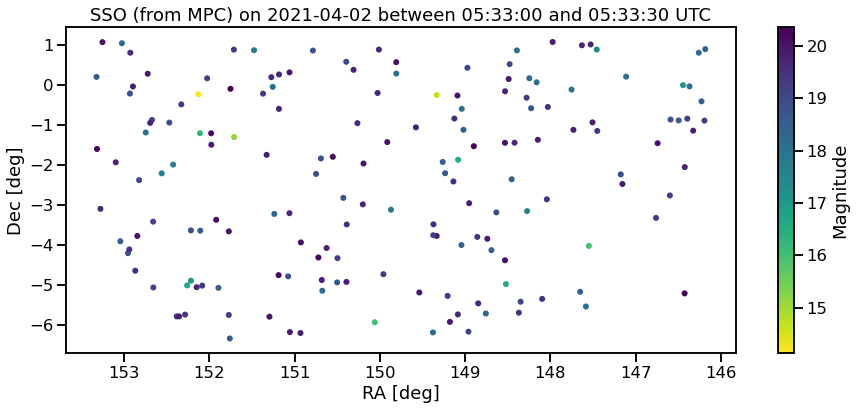

In [6]:
fig = plt.figure(figsize=(15, 6))

plt.scatter(
    pdfSSO['i:ra'], pdfSSO['i:dec'], 
    c=pdfSSO['i:magpsf'], marker='.', cmap = 'viridis_r'
)

cb = plt.colorbar(label='Magnitude')
plt.gca().invert_xaxis()
plt.title('SSO (from MPC) on 2021-04-02 between 05:33:00 and 05:33:30 UTC')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]');

### Going further

You can then use the lightcurve, for example, to extract orbital parameters (or in this case, just query MPC directly as they are known objects). Of course, you will need observations over a long period of time, but the database is only growing with time! For those interested, we put some interesting API/library to manipulate Solar System data (in addition to what is available in `astropy`):

- skybot (cone-search utility for Solar system objects, available from astropy as well): http://vo.imcce.fr/webservices/skybot/
- Astropy affiliated package for asteroid and comet data: https://sbpy.org/

## Case study 2: New SSO candidates from Fink

### Association criterion and nightly rate 

Perhaps, more exciting than compiling more observations of known objects is to observe new objects. In Fink, in addition to the filter that associate alerts to known MPC objects, we also have a filter that try to select potential new SSO object. The steps are the following:
- the alert must not be associated to a known MPC object (see above)
- the alert should not be within 5 arcseconds to any known object from PANSTARRS (DR1).
- the number of prior detection of the alert is maximum 1 (i.e. spatial association to another alert).
- if there is a prior detection, it should be within the last 30 minutes.

This reduces the volume to a few hundred candidates per night (over initially ~300,000 alerts).

### Querying the Fink database by class

You can easily query the Fink database for new SSO candidates.  

In [7]:
# dates are UTC
r = requests.post(
  'https://fink-portal.org/api/v1/latests',
  json={
    'class': 'Solar System candidate',
    'n': '1000', # limit to 1000 alerts (max is 1000)
    'startdate': '2021-04-02 04:00:00', # UTC, can be JD or MJD as well
    'stopdate': '2021-04-02 10:00:00' # UTC, can be JD or MJD as well
  }
)

# Format output in a DataFrame
pdfSSOcandidate = pd.read_json(io.BytesIO(r.content))

Let's plot their position, color coded by ZTF field ID:

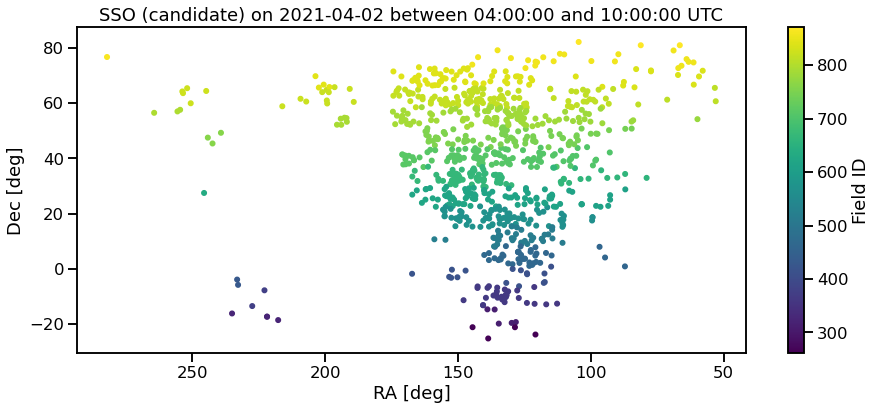

In [8]:
fig = plt.figure(figsize=(15, 6))

plt.scatter(
    pdfSSOcandidate['i:ra'], pdfSSOcandidate['i:dec'], 
    c=pdfSSOcandidate['i:field'], marker='.', cmap = 'viridis'
)

cb = plt.colorbar(label='Field ID')
plt.gca().invert_xaxis()
plt.title('SSO (candidate) on 2021-04-02 between 04:00:00 and 10:00:00 UTC')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]');

Then the game would be to first try to link objects within the same night, and then between nights to reconstruct potential tracks.

## Case study 3: Man-made objects and space-debris

### Very fast moving objects

From time to time, one can see, on a single exposure, a dozen of alerts making a discrete streak. Let's look at one of them:

In [9]:
# dates are UTC
r = requests.post(
  'https://fink-portal.org/api/v1/explorer',
  json={
    'startdate': '2021-03-18 12:33:03.996',
    'window': '1', # in minute
  }
)

# Format output in a DataFrame
pdfUFO = pd.read_json(io.BytesIO(r.content))

Let's plot their position, color coded by magnitude:

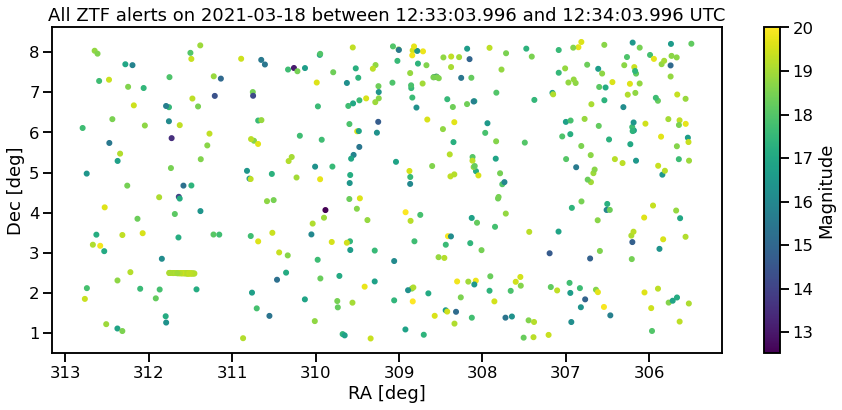

In [10]:
fig = plt.figure(figsize=(15, 6))

plt.scatter(
    pdfUFO['i:ra'], pdfUFO['i:dec'], 
    c=pdfUFO['i:magpsf'], marker='.', cmap = 'viridis'
)

cb = plt.colorbar(label='Magnitude')
plt.gca().invert_xaxis()
plt.title('All ZTF alerts on 2021-03-18 between 12:33:03.996 and 12:34:03.996 UTC')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]');

Do you see the group of alerts at the bottom left corner? Let's zoom in:

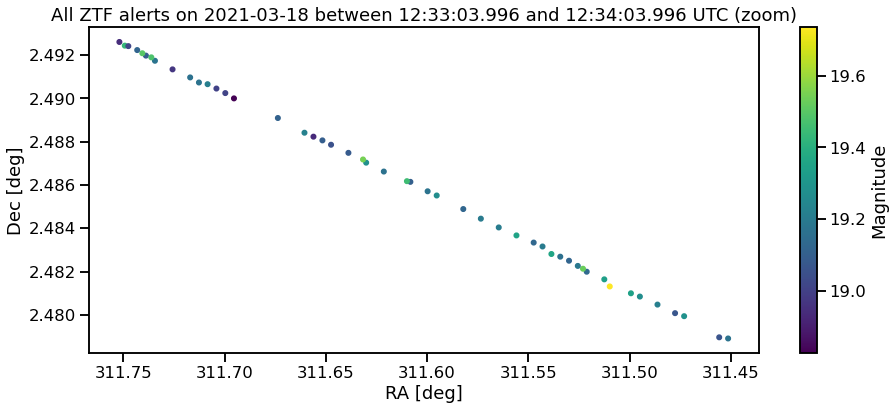

In [11]:
fig = plt.figure(figsize=(15, 6))

ra_filt = (pdfUFO['i:ra'] > 311) & (pdfUFO['i:ra'] < 312)
dec_filt = (pdfUFO['i:dec'] > 2.4) & (pdfUFO['i:dec'] < 2.6)
mask = ra_filt & dec_filt
#pdfUFO['v:classification'].isin(['Solar System candidate'])
plt.scatter(
    pdfUFO[mask]['i:ra'], pdfUFO[mask]['i:dec'], 
    c=pdfUFO[mask]['i:magpsf'], marker='.', cmap = 'viridis'
)

cb = plt.colorbar(label='Magnitude')
plt.gca().invert_xaxis()
plt.title('All ZTF alerts on 2021-03-18 between 12:33:03.996 and 12:34:03.996 UTC (zoom)')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]');

That's about 1 degree in one exposure (30 seconds) -- quite fast! Let's see the magnitude plot. As all alerts were emitted on the same exposure, we do not have access to their exact emission time, so we will use the coordinate `RA` as a proxy (assuming it is monotonically varying):

/tmp/ipykernel_609396/468255103.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pdfUFO_sorted = pdfUFO.sort_values('i:ra')[mask]


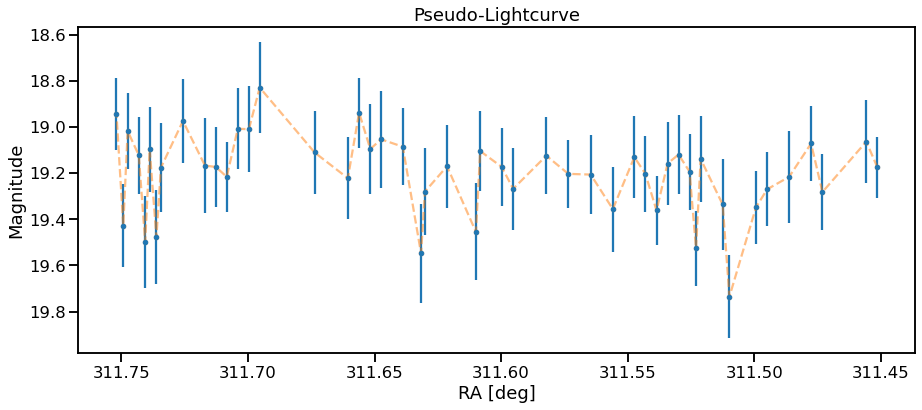

In [12]:
fig = plt.figure(figsize=(15, 6))

ra_filt = (pdfUFO['i:ra'] > 311) & (pdfUFO['i:ra'] < 312)
dec_filt = (pdfUFO['i:dec'] > 2.4) & (pdfUFO['i:dec'] < 2.6)
mask = ra_filt & dec_filt

# sort values by RA that acts as a proxy for the arrow of time
pdfUFO_sorted = pdfUFO.sort_values('i:ra')[mask]

plt.errorbar(
    pdfUFO_sorted['i:ra'], 
    pdfUFO_sorted['i:magpsf'], 
    pdfUFO_sorted['i:sigmapsf'], 
    marker='.', ls=''
)

plt.plot(
    pdfUFO_sorted['i:ra'], 
    pdfUFO_sorted['i:magpsf'], 
    marker='.', ls='--', alpha=0.5
)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title('Pseudo-Lightcurve')
plt.xlabel('RA [deg]')
plt.ylabel('Magnitude');

Interesting! Could it be a rotating object that makes this lightcurve? More information at https://arxiv.org/abs/2202.05719

## How to reach us

An issue to report, or a question to ask: contact@fink-broker.org!